In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math

In [2]:
df_elev = pd.read_csv('track_with_elevation.csv')
df_elev.head()

,track,lat,lon,elevation
0,Via Patakbanteng 001,-7.209568,109.925435,1996.0
1,Via Patakbanteng 001,-7.209640,109.925450,1996.0
2,Via Patakbanteng 001,-7.209698,109.925453,1996.0
3,Via Patakbanteng 001,-7.209734,109.925416,1996.0
4,Via Patakbanteng 001,-7.209695,109.925361,1996.0


In [3]:
segments = []

for i in range(len(df_elev) - 1):
    lat1, lon1, ele1 = df_elev.loc[i, ["lat", "lon", "elevation"]]
    lat2, lon2, ele2 = df_elev.loc[i+1, ["lat", "lon", "elevation"]]

    # -----------------------------
    # a) segment length (meters)
    # -----------------------------
    R = 6371000
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = (math.sin(dphi/2)**2 +
         math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2)
    dist = 2 * R * math.atan2(np.sqrt(a), np.sqrt(1 - a))

    # -----------------------------
    # b) slope (elevation gain / distance)
    # -----------------------------
    if dist == 0:
        slope = 0
    else:
        slope = (ele2 - ele1) / dist  # meters per meter → unitless

    # -----------------------------
    # c) curvature (perubahan heading)
    # -----------------------------
    # heading i → i+1
    heading1 = math.atan2(
        math.radians(lon2 - lon1),
        math.radians(lat2 - lat1)
    )

    # heading i+1 → i+2 (kalau ada)
    if i < len(df_elev) - 2:
        lat3, lon3 = df_elev.loc[i+2, ["lat", "lon"]]
        heading2 = math.atan2(
            math.radians(lon3 - lon2),
            math.radians(lat3 - lat2)
        )
        curvature = abs(heading2 - heading1)
    else:
        curvature = 0  # segment terakhir

    # simpan
    segments.append({
        "segment_id": i,
        "lat": lat1,
        "lon": lon1,
        "length_m": dist,
        "slope": slope,
        "curvature": curvature
    })

df_seg = pd.DataFrame(segments)

In [4]:
df_seg

,segment_id,lat,lon,length_m,slope,curvature
0,0,-7.209568,109.925435,8.131323,0.0,0.161757
1,1,-7.209640,109.925450,6.521666,0.0,5.448443
2,2,-7.209698,109.925453,5.651978,0.0,1.391117
3,3,-7.209734,109.925416,7.517339,0.0,0.969437
4,4,-7.209695,109.925361,17.765037,0.0,0.054262
...,...,...,...,...,...,...
1302,1302,-7.201109,109.935774,9.320755,0.0,0.785576
1303,1303,-7.201109,109.935689,4.411615,0.0,1.570974
1304,1304,-7.201137,109.935661,4.412391,0.0,0.197150
1305,1305,-7.201109,109.935633,11.242127,0.0,0.982548


In [5]:
df_track_1 = pd.read_csv('device_track_1.csv')
df_track_1.head()

,track_id,device_id,timestamp,longitude,latitude,battery_level,emergency_status,condition,off_track,segment_id
0,T-WAT_1-1762845227.0,WAT_1,2025-11-11 07:13:47,109.959301,-7.224694,65.96,False,badai petir,False,771.0
1,T-WAT_1-1762845287.0,WAT_1,2025-11-11 07:14:47,109.958848,-7.224514,65.91,False,badai petir,False,778.0
2,T-WAT_1-1762845347.0,WAT_1,2025-11-11 07:15:47,109.958525,-7.224461,65.90,False,badai petir,False,780.0
3,T-WAT_1-1762845407.0,WAT_1,2025-11-11 07:16:47,109.958535,-7.224219,65.85,False,badai petir,False,783.0
4,T-WAT_1-1762845467.0,WAT_1,2025-11-11 07:17:47,109.958295,-7.223958,65.81,False,badai petir,False,788.0


In [6]:
def closest_segment(lat, lon):
    d = (df_seg["lat"] - lat)**2 + (df_seg["lon"] - lon)**2
    return d.idxmin()

df_track_1["segment_id"] = df_track_1.apply(
    lambda row: closest_segment(row["latitude"], row["longitude"]), axis=1
)

In [7]:
df_seg.head()

,segment_id,lat,lon,length_m,slope,curvature
0,0,-7.209568,109.925435,8.131323,0.0,0.161757
1,1,-7.209640,109.925450,6.521666,0.0,5.448443
2,2,-7.209698,109.925453,5.651978,0.0,1.391117
3,3,-7.209734,109.925416,7.517339,0.0,0.969437
4,4,-7.209695,109.925361,17.765037,0.0,0.054262


In [8]:
df_track_1.head()

,track_id,device_id,timestamp,longitude,latitude,battery_level,emergency_status,condition,off_track,segment_id
0,T-WAT_1-1762845227.0,WAT_1,2025-11-11 07:13:47,109.959301,-7.224694,65.96,False,badai petir,False,771
1,T-WAT_1-1762845287.0,WAT_1,2025-11-11 07:14:47,109.958848,-7.224514,65.91,False,badai petir,False,778
2,T-WAT_1-1762845347.0,WAT_1,2025-11-11 07:15:47,109.958525,-7.224461,65.90,False,badai petir,False,780
3,T-WAT_1-1762845407.0,WAT_1,2025-11-11 07:16:47,109.958535,-7.224219,65.85,False,badai petir,False,783
4,T-WAT_1-1762845467.0,WAT_1,2025-11-11 07:17:47,109.958295,-7.223958,65.81,False,badai petir,False,788


In [9]:
df_emergency = pd.read_csv("emergency_events (1).csv")
df_emergency

,emergency_id,device_id,timestamp,longitude,latitude,emergency_type,resolved
0,E-1,WAT_4,2025-11-11T03:17:45,109.946558,-7.209522,Stuck,False
1,E-2,WAT_4,2025-11-11T07:08:45,109.936904,-7.200799,Stuck,False
2,E-3,WAT_5,2025-11-11T04:56:37,109.958083,-7.222721,Stuck,False
3,E-4,WAT_6,2025-11-11T11:11:17,109.936269,-7.200913,Stuck,False
4,E-5,WAT_11,2025-11-11T07:57:49,109.944063,-7.210272,Stuck,False
...,...,...,...,...,...,...,...
186,E-187,WAT_1949,2025-11-13T05:18:06,109.938767,-7.204125,Stuck,False
187,E-188,DIE_1977,2025-11-13T04:09:21,109.919775,-7.189580,Stuck,False
188,E-189,DIE_2066,2025-11-13T03:35:35,109.913537,-7.201070,Stuck,False
189,E-190,DIE_2090,2025-11-13T12:35:11,109.917694,-7.197187,Stuck,False


In [10]:
df_emergency["segment_id"] = df_emergency.apply(
    lambda row: closest_segment(row["latitude"], row["longitude"]), axis=1
)

In [11]:
df_emergency

,emergency_id,device_id,timestamp,longitude,latitude,emergency_type,resolved,segment_id
0,E-1,WAT_4,2025-11-11T03:17:45,109.946558,-7.209522,Stuck,False,1071
1,E-2,WAT_4,2025-11-11T07:08:45,109.936904,-7.200799,Stuck,False,1284
2,E-3,WAT_5,2025-11-11T04:56:37,109.958083,-7.222721,Stuck,False,815
3,E-4,WAT_6,2025-11-11T11:11:17,109.936269,-7.200913,Stuck,False,1293
4,E-5,WAT_11,2025-11-11T07:57:49,109.944063,-7.210272,Stuck,False,1105
...,...,...,...,...,...,...,...,...
186,E-187,WAT_1949,2025-11-13T05:18:06,109.938767,-7.204125,Stuck,False,1232
187,E-188,DIE_1977,2025-11-13T04:09:21,109.919775,-7.189580,Stuck,False,567
188,E-189,DIE_2066,2025-11-13T03:35:35,109.913537,-7.201070,Stuck,False,300
189,E-190,DIE_2090,2025-11-13T12:35:11,109.917694,-7.197187,Stuck,False,384


In [12]:
# hitung fitur tambahan
seg_stats = df_track_1.groupby("segment_id").agg({
    "device_id": "count",
    "off_track": "mean"
}).rename(columns={
    "device_id": "density",
    "off_track": "offtrack_rate"
}).reset_index()

df_seg = df_seg.merge(seg_stats, on="segment_id", how="left")

df_seg.fillna({
    "density": 0,
    "offtrack_rate": 0
}, inplace=True)

In [13]:
stuck_emg = df_emergency[df_emergency['emergency_type'] == 'Stuck']
stuck_emg.head()

,emergency_id,device_id,timestamp,longitude,latitude,emergency_type,resolved,segment_id
0,E-1,WAT_4,2025-11-11T03:17:45,109.946558,-7.209522,Stuck,False,1071
1,E-2,WAT_4,2025-11-11T07:08:45,109.936904,-7.200799,Stuck,False,1284
2,E-3,WAT_5,2025-11-11T04:56:37,109.958083,-7.222721,Stuck,False,815
3,E-4,WAT_6,2025-11-11T11:11:17,109.936269,-7.200913,Stuck,False,1293
4,E-5,WAT_11,2025-11-11T07:57:49,109.944063,-7.210272,Stuck,False,1105


In [14]:
sos_emg = df_emergency[df_emergency["emergency_type"] == 'SOS']
sos_emg

,emergency_id,device_id,timestamp,longitude,latitude,emergency_type,resolved,segment_id
82,E-83,WAT_207,2025-11-11T22:52:04,109.920021,-7.189404,SOS,False,577
108,E-109,PAT_605,2025-11-11T09:26:35,109.938761,-7.204180,SOS,False,1232


In [15]:
df_seg.to_csv('df_seg.csv', index=False)

In [16]:
stuck_stats = stuck_emg.groupby("segment_id").agg({
    "emergency_id":"count"
}).rename(columns={"emergency_id":"stuck_count"}).reset_index()

df_seg = df_seg.merge(stuck_stats, on="segment_id", how="left")

df_seg.fillna({
    "stuck_count": 0
}, inplace=True)

In [17]:
sos_stats = sos_emg.groupby("segment_id").agg({
    "emergency_id":"count"
}).rename(columns={"emergency_id":"sos_count"}).reset_index()

df_seg = df_seg.merge(sos_stats, on="segment_id", how="left")

df_seg.fillna({
    "sos_count": 0
}, inplace=True)

In [18]:
df_seg

,segment_id,lat,lon,length_m,slope,curvature,density,offtrack_rate,stuck_count,sos_count
0,0,-7.209568,109.925435,8.131323,0.0,0.161757,257.0,0.031128,0.0,0.0
1,1,-7.209640,109.925450,6.521666,0.0,5.448443,115.0,0.034783,0.0,0.0
2,2,-7.209698,109.925453,5.651978,0.0,1.391117,65.0,0.030769,0.0,0.0
3,3,-7.209734,109.925416,7.517339,0.0,0.969437,60.0,0.100000,0.0,0.0
4,4,-7.209695,109.925361,17.765037,0.0,0.054262,122.0,0.049180,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1302,1302,-7.201109,109.935774,9.320755,0.0,0.785576,72.0,0.027778,0.0,0.0
1303,1303,-7.201109,109.935689,4.411615,0.0,1.570974,48.0,0.020833,0.0,0.0
1304,1304,-7.201137,109.935661,4.412391,0.0,0.197150,31.0,0.129032,0.0,0.0
1305,1305,-7.201109,109.935633,11.242127,0.0,0.982548,52.0,0.019231,0.0,0.0


In [19]:
from sklearn.cluster import KMeans

In [38]:
features = df_seg[['slope', 'curvature', 'offtrack_rate', 'stuck_count', 'sos_count']]

# Standarisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, max_iter=100, random_state=42)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

In [39]:
df_seg["cluster"] = y_kmeans

# Check result
print(df_seg.head())

   segment_id       lat         lon   length_m  slope  curvature  density  \
0           0 -7.209568  109.925435   8.131323    0.0   0.161757    257.0   
1           1 -7.209640  109.925450   6.521666    0.0   5.448443    115.0   
2           2 -7.209698  109.925453   5.651978    0.0   1.391117     65.0   
3           3 -7.209734  109.925416   7.517339    0.0   0.969437     60.0   
4           4 -7.209695  109.925361  17.765037    0.0   0.054262    122.0   

   offtrack_rate  stuck_count  sos_count  cluster  
0       0.031128          0.0        0.0        0  
1       0.034783          0.0        0.0        0  
2       0.030769          0.0        0.0        0  
3       0.100000          0.0        0.0        0  
4       0.049180          0.0        0.0        0  


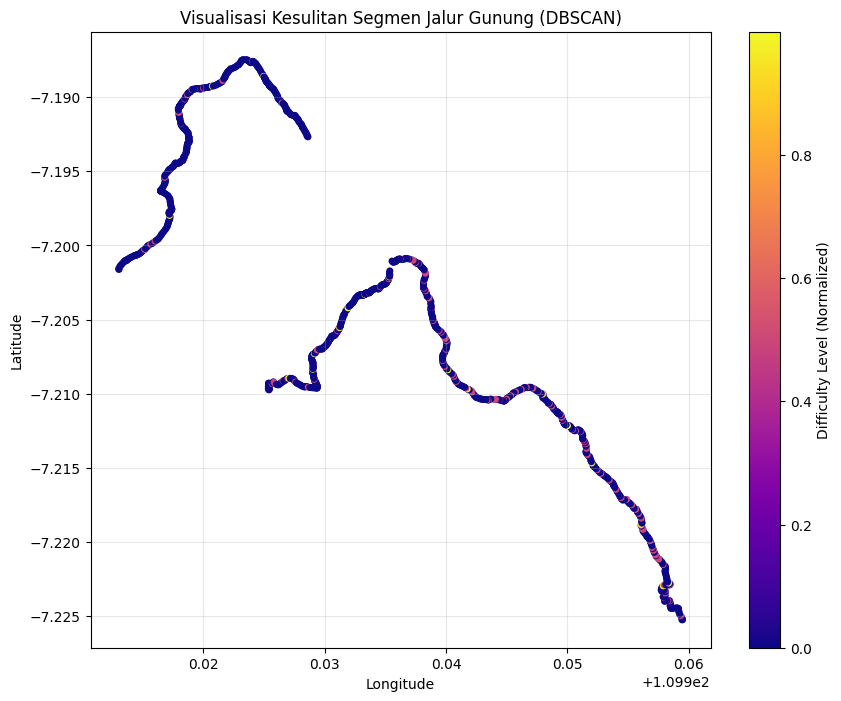

In [40]:
import matplotlib.pyplot as plt

difficulty = df_seg['cluster']
norm = (difficulty - difficulty.min()) / (difficulty.max() - difficulty.min() + 1e-9)

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    df_seg["lon"],
    df_seg["lat"],
    c=norm,
    cmap="plasma",     # bisa diganti viridis, inferno, turbo, magma, dll
    s=25,
    edgecolor="none"
)

plt.colorbar(sc, label="Difficulty Level (Normalized)")
plt.title("Visualisasi Kesulitan Segmen Jalur Gunung (DBSCAN)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)

plt.show()

In [41]:
from sklearn import metrics

labels = kmeans.labels_
sc = metrics.silhouette_score(X, labels)
print("Silhouette Coefficient:%0.2f" % sc)

Silhouette Coefficient:0.69


In [42]:
diff_count = df_seg.groupby("cluster").agg({
    "segment_id": "count"
})
print(diff_count)

         segment_id
cluster            
0              1163
1               126
2                18
